In [1]:
#https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
import numpy as np
from numpy import concatenate
from math import sqrt
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [2]:
# convert series to supervised learning & normalize input variables
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
def data_preparation(df):
    # Get names of indexes for which column temporarily_unable_test has value 1000
    index = df[ df['number_busy'] > 2000 ].index
    # Delete these row indexes from dataFrame
    df.drop(index , inplace=True)
    
    # Get names of indexes for which column temporarily_unable_test has value 1000
    index = df[ df['temporarily_unable_test'] > 1000 ].index
    # Delete these row indexes from dataFrame
    df.drop(index , inplace=True)
    
    # Use a log transformation to decrease the impact of extreme values in column followup_tests
    df['followup_tests'] = np.log(df['followup_tests'] + 1)
    
    # Get names of indexes for which column outage_hrs has value > 300 
    index = df[ df['quality_too_poor'] > 300 ].index
    # Delete these row indexes from dataFrame
    df.drop(index , inplace=True)
    
    # Use a log transformation to decrease the impact of extreme values in column followup_tests
    df['outage_hrs'] = np.log(df['outage_hrs'])
    
    # Use a log transformation to decrease the impact of extreme values in column followup_tests
    df['numbers_tested'] = np.log(df['numbers_tested'])
    
    #df.drop(['followup_tests','outage_hrs', 'numbers_tested'], inplace=True, axis=1)
    
    return df

In [4]:
# load dataset
df = read_csv('../reports/company_report_2.csv', header=0, index_col="time") #2, 9, 49, 93, 130
df = df[['volume_tests', 'date', 'month', 'is_weekend', 'quality_too_poor', 'number_busy', 'temporarily_unable_test', 'outage_hrs', 'number_test_types', 'numbers_tested', 'min_commit']]

# drop columns where nan or replace nan with mean
df = df.dropna(axis='columns', how='all')
df.iloc[:, -1] = df.iloc[:, -1].fillna(df.iloc[:, -1].mean())

# get datframe values
values = df.values

# specify the number of days and features 
n_input = 7
n_features = df.shape[1]
n_predict = 7

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, n_input, n_predict)
print(reframed.shape)

(1250, 154)


In [5]:
# split into train and test sets
values = reframed.values

# train and test size
train_size = int(len(values) * 0.8)
test_size = len(values) - train_size
train, test = values[:train_size,:], values[train_size:,:]

# split into input and outputs
n_obs = n_input * n_features
n_predict_obs = n_predict * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_predict_obs::n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_predict_obs::n_features]
print(train_X.shape, len(train_X), train_y.shape)

# split into inputs and output (cross-validation)
X, y = values[:, :n_obs], values[:, -n_predict_obs::n_features]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_input, n_features))
X = X.reshape((X.shape[0], n_input, n_features))
test_X = test_X.reshape((test_X.shape[0], n_input, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1000, 77) 1000 (1000, 7)
(1000, 7, 11) (1000, 7) (250, 7, 11) (250, 7)


Train on 1125 samples, validate on 125 samples
Epoch 1/100
1125/1125 - 3s - loss: 0.1446 - accuracy: 0.1564 - val_loss: 0.0425 - val_accuracy: 0.1600
Epoch 2/100
1125/1125 - 0s - loss: 0.0747 - accuracy: 0.1573 - val_loss: 0.0394 - val_accuracy: 0.1920
Epoch 3/100
1125/1125 - 0s - loss: 0.0636 - accuracy: 0.1564 - val_loss: 0.0393 - val_accuracy: 0.2240
Epoch 4/100
1125/1125 - 0s - loss: 0.0566 - accuracy: 0.1831 - val_loss: 0.0383 - val_accuracy: 0.2320
Epoch 5/100
1125/1125 - 0s - loss: 0.0505 - accuracy: 0.1982 - val_loss: 0.0368 - val_accuracy: 0.2720
Epoch 6/100
1125/1125 - 0s - loss: 0.0455 - accuracy: 0.2044 - val_loss: 0.0353 - val_accuracy: 0.2800
Epoch 7/100
1125/1125 - 0s - loss: 0.0414 - accuracy: 0.2320 - val_loss: 0.0342 - val_accuracy: 0.2960
Epoch 8/100
1125/1125 - 0s - loss: 0.0381 - accuracy: 0.2622 - val_loss: 0.0320 - val_accuracy: 0.2960
Epoch 9/100
1125/1125 - 0s - loss: 0.0342 - accuracy: 0.2747 - val_loss: 0.0270 - val_accuracy: 0.3760
Epoch 10/100
1125/1125 - 0

Epoch 80/100
1125/1125 - 0s - loss: 0.0065 - accuracy: 0.3209 - val_loss: 0.0019 - val_accuracy: 0.1920
Epoch 81/100
1125/1125 - 0s - loss: 0.0065 - accuracy: 0.3102 - val_loss: 0.0019 - val_accuracy: 0.2000
Epoch 82/100
1125/1125 - 0s - loss: 0.0067 - accuracy: 0.2747 - val_loss: 0.0019 - val_accuracy: 0.2400
Epoch 83/100
1125/1125 - 0s - loss: 0.0065 - accuracy: 0.2853 - val_loss: 0.0019 - val_accuracy: 0.2400
Epoch 84/100
1125/1125 - 0s - loss: 0.0066 - accuracy: 0.2933 - val_loss: 0.0018 - val_accuracy: 0.2320
Epoch 85/100
1125/1125 - 0s - loss: 0.0067 - accuracy: 0.2640 - val_loss: 0.0019 - val_accuracy: 0.2080
Epoch 86/100
1125/1125 - 0s - loss: 0.0062 - accuracy: 0.2996 - val_loss: 0.0018 - val_accuracy: 0.1760
Epoch 87/100
1125/1125 - 0s - loss: 0.0066 - accuracy: 0.2978 - val_loss: 0.0019 - val_accuracy: 0.2000
Epoch 88/100
1125/1125 - 0s - loss: 0.0067 - accuracy: 0.3102 - val_loss: 0.0018 - val_accuracy: 0.1920
Epoch 89/100
1125/1125 - 1s - loss: 0.0067 - accuracy: 0.3120 - 

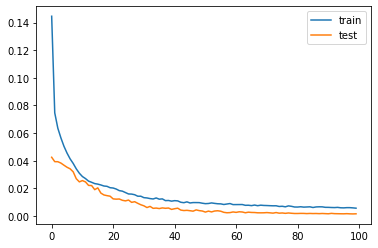

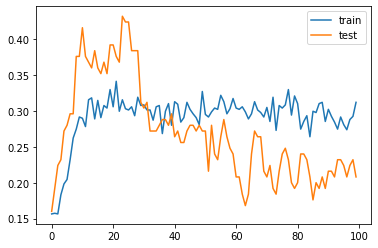

Test loss:0.28%
Test score:39.60%
Train on 1125 samples, validate on 125 samples
Epoch 1/100
1125/1125 - 0s - loss: 0.0057 - accuracy: 0.2969 - val_loss: 0.0015 - val_accuracy: 0.2960
Epoch 2/100
1125/1125 - 0s - loss: 0.0058 - accuracy: 0.2933 - val_loss: 0.0021 - val_accuracy: 0.3280
Epoch 3/100
1125/1125 - 0s - loss: 0.0058 - accuracy: 0.2818 - val_loss: 0.0021 - val_accuracy: 0.2880
Epoch 4/100
1125/1125 - 0s - loss: 0.0059 - accuracy: 0.2578 - val_loss: 0.0017 - val_accuracy: 0.3280
Epoch 5/100
1125/1125 - 0s - loss: 0.0058 - accuracy: 0.2924 - val_loss: 0.0018 - val_accuracy: 0.2960
Epoch 6/100
1125/1125 - 0s - loss: 0.0056 - accuracy: 0.2622 - val_loss: 0.0022 - val_accuracy: 0.2800
Epoch 7/100
1125/1125 - 0s - loss: 0.0059 - accuracy: 0.3049 - val_loss: 0.0017 - val_accuracy: 0.2560
Epoch 8/100
1125/1125 - 0s - loss: 0.0056 - accuracy: 0.2782 - val_loss: 0.0017 - val_accuracy: 0.2800
Epoch 9/100
1125/1125 - 0s - loss: 0.0056 - accuracy: 0.2916 - val_loss: 0.0017 - val_accuracy:

1125/1125 - 0s - loss: 0.0044 - accuracy: 0.2676 - val_loss: 0.0015 - val_accuracy: 0.3360
Epoch 80/100
1125/1125 - 0s - loss: 0.0041 - accuracy: 0.2880 - val_loss: 0.0016 - val_accuracy: 0.3120
Epoch 81/100
1125/1125 - 0s - loss: 0.0042 - accuracy: 0.2738 - val_loss: 0.0019 - val_accuracy: 0.2800
Epoch 82/100
1125/1125 - 0s - loss: 0.0044 - accuracy: 0.2631 - val_loss: 0.0017 - val_accuracy: 0.3120
Epoch 83/100
1125/1125 - 0s - loss: 0.0042 - accuracy: 0.2720 - val_loss: 0.0015 - val_accuracy: 0.3120
Epoch 84/100
1125/1125 - 0s - loss: 0.0042 - accuracy: 0.2507 - val_loss: 0.0017 - val_accuracy: 0.2880
Epoch 85/100
1125/1125 - 0s - loss: 0.0045 - accuracy: 0.2711 - val_loss: 0.0018 - val_accuracy: 0.3040
Epoch 86/100
1125/1125 - 0s - loss: 0.0042 - accuracy: 0.2960 - val_loss: 0.0027 - val_accuracy: 0.3200
Epoch 87/100
1125/1125 - 0s - loss: 0.0042 - accuracy: 0.2640 - val_loss: 0.0016 - val_accuracy: 0.3040
Epoch 88/100
1125/1125 - 0s - loss: 0.0043 - accuracy: 0.2498 - val_loss: 0.0

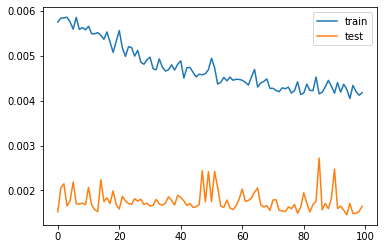

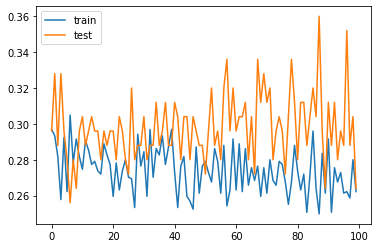

Test loss:0.21%
Test score:36.40%
Train on 1125 samples, validate on 125 samples
Epoch 1/100
1125/1125 - 0s - loss: 0.0040 - accuracy: 0.2587 - val_loss: 0.0013 - val_accuracy: 0.3280
Epoch 2/100
1125/1125 - 1s - loss: 0.0039 - accuracy: 0.2684 - val_loss: 0.0014 - val_accuracy: 0.3680
Epoch 3/100
1125/1125 - 1s - loss: 0.0040 - accuracy: 0.2471 - val_loss: 0.0015 - val_accuracy: 0.3680
Epoch 4/100
1125/1125 - 0s - loss: 0.0039 - accuracy: 0.2720 - val_loss: 0.0016 - val_accuracy: 0.2880
Epoch 5/100
1125/1125 - 0s - loss: 0.0039 - accuracy: 0.2453 - val_loss: 0.0017 - val_accuracy: 0.3440
Epoch 6/100
1125/1125 - 1s - loss: 0.0041 - accuracy: 0.2684 - val_loss: 0.0020 - val_accuracy: 0.3440
Epoch 7/100
1125/1125 - 0s - loss: 0.0040 - accuracy: 0.2587 - val_loss: 0.0019 - val_accuracy: 0.3520
Epoch 8/100
1125/1125 - 1s - loss: 0.0041 - accuracy: 0.2551 - val_loss: 0.0024 - val_accuracy: 0.4080
Epoch 9/100
1125/1125 - 0s - loss: 0.0040 - accuracy: 0.2551 - val_loss: 0.0035 - val_accuracy:

1125/1125 - 0s - loss: 0.0038 - accuracy: 0.2622 - val_loss: 0.0025 - val_accuracy: 0.3840
Epoch 80/100
1125/1125 - 0s - loss: 0.0040 - accuracy: 0.2622 - val_loss: 0.0022 - val_accuracy: 0.4000
Epoch 81/100
1125/1125 - 0s - loss: 0.0039 - accuracy: 0.2551 - val_loss: 0.0026 - val_accuracy: 0.3520
Epoch 82/100
1125/1125 - 0s - loss: 0.0039 - accuracy: 0.2960 - val_loss: 0.0031 - val_accuracy: 0.3440
Epoch 83/100
1125/1125 - 0s - loss: 0.0042 - accuracy: 0.2373 - val_loss: 0.0035 - val_accuracy: 0.3200
Epoch 84/100
1125/1125 - 0s - loss: 0.0038 - accuracy: 0.2409 - val_loss: 0.0024 - val_accuracy: 0.3600
Epoch 85/100
1125/1125 - 0s - loss: 0.0039 - accuracy: 0.2702 - val_loss: 0.0019 - val_accuracy: 0.3280
Epoch 86/100
1125/1125 - 0s - loss: 0.0039 - accuracy: 0.2444 - val_loss: 0.0020 - val_accuracy: 0.2960
Epoch 87/100
1125/1125 - 0s - loss: 0.0039 - accuracy: 0.2720 - val_loss: 0.0026 - val_accuracy: 0.3520
Epoch 88/100
1125/1125 - 0s - loss: 0.0036 - accuracy: 0.2444 - val_loss: 0.0

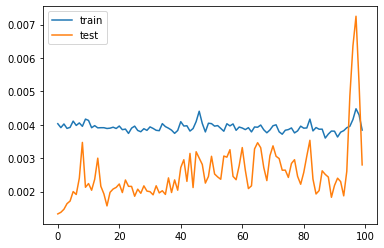

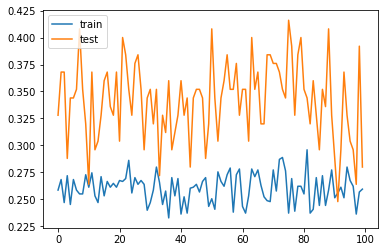

Test loss:0.22%
Test score:32.80%
Train on 1125 samples, validate on 125 samples
Epoch 1/100
1125/1125 - 0s - loss: 0.0039 - accuracy: 0.2356 - val_loss: 0.0012 - val_accuracy: 0.2880
Epoch 2/100
1125/1125 - 0s - loss: 0.0039 - accuracy: 0.2631 - val_loss: 0.0012 - val_accuracy: 0.2240
Epoch 3/100
1125/1125 - 0s - loss: 0.0039 - accuracy: 0.2569 - val_loss: 0.0012 - val_accuracy: 0.2720
Epoch 4/100
1125/1125 - 0s - loss: 0.0040 - accuracy: 0.2507 - val_loss: 0.0015 - val_accuracy: 0.2640
Epoch 5/100
1125/1125 - 0s - loss: 0.0040 - accuracy: 0.2444 - val_loss: 0.0016 - val_accuracy: 0.2560
Epoch 6/100
1125/1125 - 0s - loss: 0.0039 - accuracy: 0.2711 - val_loss: 0.0018 - val_accuracy: 0.2400
Epoch 7/100
1125/1125 - 0s - loss: 0.0039 - accuracy: 0.2578 - val_loss: 0.0018 - val_accuracy: 0.2400
Epoch 8/100
1125/1125 - 0s - loss: 0.0040 - accuracy: 0.2800 - val_loss: 0.0017 - val_accuracy: 0.2640
Epoch 9/100
1125/1125 - 0s - loss: 0.0039 - accuracy: 0.2818 - val_loss: 0.0017 - val_accuracy:

Epoch 80/100
1125/1125 - 0s - loss: 0.0038 - accuracy: 0.2676 - val_loss: 0.0017 - val_accuracy: 0.2880
Epoch 81/100
1125/1125 - 0s - loss: 0.0037 - accuracy: 0.2676 - val_loss: 0.0024 - val_accuracy: 0.2640
Epoch 82/100
1125/1125 - 0s - loss: 0.0038 - accuracy: 0.2587 - val_loss: 0.0024 - val_accuracy: 0.3040
Epoch 83/100
1125/1125 - 0s - loss: 0.0037 - accuracy: 0.2622 - val_loss: 0.0019 - val_accuracy: 0.2960
Epoch 84/100
1125/1125 - 0s - loss: 0.0036 - accuracy: 0.2933 - val_loss: 0.0019 - val_accuracy: 0.3040
Epoch 85/100
1125/1125 - 0s - loss: 0.0039 - accuracy: 0.2516 - val_loss: 0.0018 - val_accuracy: 0.2960
Epoch 86/100
1125/1125 - 0s - loss: 0.0042 - accuracy: 0.2622 - val_loss: 0.0027 - val_accuracy: 0.2480
Epoch 87/100
1125/1125 - 0s - loss: 0.0041 - accuracy: 0.2569 - val_loss: 0.0034 - val_accuracy: 0.3040
Epoch 88/100
1125/1125 - 0s - loss: 0.0040 - accuracy: 0.2578 - val_loss: 0.0018 - val_accuracy: 0.2960
Epoch 89/100
1125/1125 - 0s - loss: 0.0037 - accuracy: 0.2782 - 

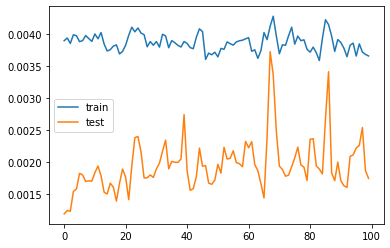

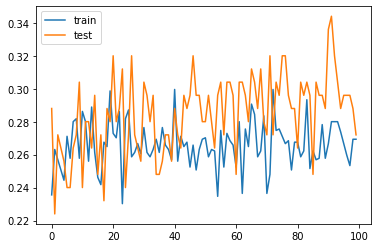

Test loss:0.23%
Test score:39.60%
Train on 1125 samples, validate on 125 samples
Epoch 1/100
1125/1125 - 0s - loss: 0.0039 - accuracy: 0.2489 - val_loss: 5.4127e-04 - val_accuracy: 0.2400
Epoch 2/100
1125/1125 - 0s - loss: 0.0041 - accuracy: 0.2542 - val_loss: 0.0011 - val_accuracy: 0.2080
Epoch 3/100
1125/1125 - 0s - loss: 0.0041 - accuracy: 0.2684 - val_loss: 9.8841e-04 - val_accuracy: 0.2000
Epoch 4/100
1125/1125 - 0s - loss: 0.0039 - accuracy: 0.2720 - val_loss: 6.7712e-04 - val_accuracy: 0.2000
Epoch 5/100
1125/1125 - 0s - loss: 0.0038 - accuracy: 0.2924 - val_loss: 5.5121e-04 - val_accuracy: 0.1920
Epoch 6/100
1125/1125 - 0s - loss: 0.0039 - accuracy: 0.2613 - val_loss: 6.2326e-04 - val_accuracy: 0.2240
Epoch 7/100
1125/1125 - 0s - loss: 0.0039 - accuracy: 0.2667 - val_loss: 4.5434e-04 - val_accuracy: 0.2080
Epoch 8/100
1125/1125 - 0s - loss: 0.0038 - accuracy: 0.2800 - val_loss: 5.1817e-04 - val_accuracy: 0.2240
Epoch 9/100
1125/1125 - 0s - loss: 0.0040 - accuracy: 0.2587 - val_

Epoch 77/100
1125/1125 - 0s - loss: 0.0038 - accuracy: 0.2827 - val_loss: 4.5229e-04 - val_accuracy: 0.2080
Epoch 78/100
1125/1125 - 0s - loss: 0.0036 - accuracy: 0.2640 - val_loss: 6.4937e-04 - val_accuracy: 0.2160
Epoch 79/100
1125/1125 - 0s - loss: 0.0037 - accuracy: 0.2516 - val_loss: 8.6580e-04 - val_accuracy: 0.2080
Epoch 80/100
1125/1125 - 0s - loss: 0.0036 - accuracy: 0.2800 - val_loss: 0.0012 - val_accuracy: 0.2400
Epoch 81/100
1125/1125 - 0s - loss: 0.0038 - accuracy: 0.2880 - val_loss: 0.0018 - val_accuracy: 0.1920
Epoch 82/100
1125/1125 - 0s - loss: 0.0038 - accuracy: 0.2578 - val_loss: 0.0011 - val_accuracy: 0.2240
Epoch 83/100
1125/1125 - 0s - loss: 0.0037 - accuracy: 0.2916 - val_loss: 5.4988e-04 - val_accuracy: 0.2080
Epoch 84/100
1125/1125 - 0s - loss: 0.0038 - accuracy: 0.2640 - val_loss: 7.1346e-04 - val_accuracy: 0.2480
Epoch 85/100
1125/1125 - 0s - loss: 0.0038 - accuracy: 0.2978 - val_loss: 7.6093e-04 - val_accuracy: 0.1920
Epoch 86/100
1125/1125 - 0s - loss: 0.00

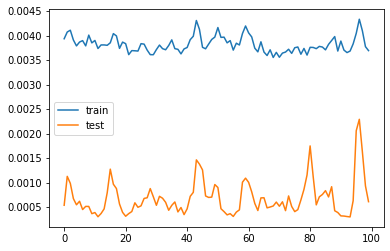

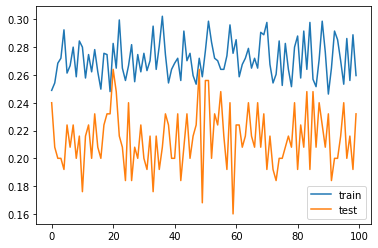

Test loss:0.18%
Test score:39.60%
Train on 1125 samples, validate on 125 samples
Epoch 1/100
1125/1125 - 0s - loss: 0.0040 - accuracy: 0.2622 - val_loss: 6.3541e-04 - val_accuracy: 0.3200
Epoch 2/100
1125/1125 - 0s - loss: 0.0041 - accuracy: 0.2773 - val_loss: 0.0014 - val_accuracy: 0.3440
Epoch 3/100
1125/1125 - 0s - loss: 0.0041 - accuracy: 0.2711 - val_loss: 7.5870e-04 - val_accuracy: 0.2960
Epoch 4/100
1125/1125 - 0s - loss: 0.0039 - accuracy: 0.2791 - val_loss: 0.0021 - val_accuracy: 0.1920
Epoch 5/100
1125/1125 - 0s - loss: 0.0042 - accuracy: 0.2738 - val_loss: 6.8021e-04 - val_accuracy: 0.2720
Epoch 6/100
1125/1125 - 0s - loss: 0.0037 - accuracy: 0.2711 - val_loss: 5.7933e-04 - val_accuracy: 0.3600
Epoch 7/100
1125/1125 - 0s - loss: 0.0037 - accuracy: 0.2773 - val_loss: 0.0013 - val_accuracy: 0.2880
Epoch 8/100
1125/1125 - 0s - loss: 0.0037 - accuracy: 0.2569 - val_loss: 7.4621e-04 - val_accuracy: 0.2480
Epoch 9/100
1125/1125 - 0s - loss: 0.0036 - accuracy: 0.2578 - val_loss: 6.

Epoch 78/100
1125/1125 - 0s - loss: 0.0037 - accuracy: 0.2702 - val_loss: 8.0110e-04 - val_accuracy: 0.2880
Epoch 79/100
1125/1125 - 0s - loss: 0.0037 - accuracy: 0.2711 - val_loss: 8.0327e-04 - val_accuracy: 0.3040
Epoch 80/100
1125/1125 - 0s - loss: 0.0036 - accuracy: 0.2898 - val_loss: 9.7914e-04 - val_accuracy: 0.2160
Epoch 81/100
1125/1125 - 0s - loss: 0.0035 - accuracy: 0.2853 - val_loss: 9.8306e-04 - val_accuracy: 0.3280
Epoch 82/100
1125/1125 - 0s - loss: 0.0037 - accuracy: 0.2658 - val_loss: 0.0011 - val_accuracy: 0.2160
Epoch 83/100
1125/1125 - 0s - loss: 0.0037 - accuracy: 0.2791 - val_loss: 0.0011 - val_accuracy: 0.3680
Epoch 84/100
1125/1125 - 0s - loss: 0.0036 - accuracy: 0.2684 - val_loss: 0.0011 - val_accuracy: 0.2880
Epoch 85/100
1125/1125 - 0s - loss: 0.0036 - accuracy: 0.2667 - val_loss: 0.0016 - val_accuracy: 0.2960
Epoch 86/100
1125/1125 - 0s - loss: 0.0036 - accuracy: 0.2809 - val_loss: 0.0011 - val_accuracy: 0.2400
Epoch 87/100
1125/1125 - 0s - loss: 0.0035 - acc

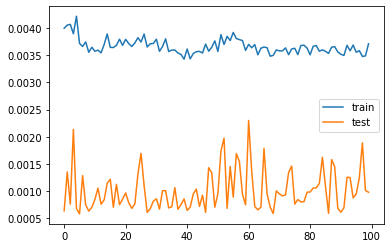

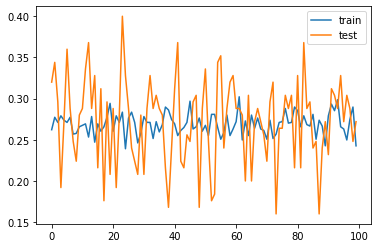

Test loss:0.19%
Test score:35.60%
Train on 1125 samples, validate on 125 samples
Epoch 1/100
1125/1125 - 0s - loss: 0.0035 - accuracy: 0.2418 - val_loss: 0.0046 - val_accuracy: 0.4720
Epoch 2/100
1125/1125 - 0s - loss: 0.0034 - accuracy: 0.2747 - val_loss: 0.0045 - val_accuracy: 0.4880
Epoch 3/100
1125/1125 - 0s - loss: 0.0032 - accuracy: 0.2524 - val_loss: 0.0043 - val_accuracy: 0.5920
Epoch 4/100
1125/1125 - 0s - loss: 0.0032 - accuracy: 0.2702 - val_loss: 0.0043 - val_accuracy: 0.5760
Epoch 5/100
1125/1125 - 0s - loss: 0.0031 - accuracy: 0.2587 - val_loss: 0.0044 - val_accuracy: 0.5280
Epoch 6/100
1125/1125 - 0s - loss: 0.0032 - accuracy: 0.2667 - val_loss: 0.0042 - val_accuracy: 0.5520
Epoch 7/100
1125/1125 - 0s - loss: 0.0031 - accuracy: 0.2382 - val_loss: 0.0045 - val_accuracy: 0.5920
Epoch 8/100
1125/1125 - 0s - loss: 0.0032 - accuracy: 0.2516 - val_loss: 0.0043 - val_accuracy: 0.5760
Epoch 9/100
1125/1125 - 0s - loss: 0.0032 - accuracy: 0.2676 - val_loss: 0.0044 - val_accuracy:

Epoch 80/100
1125/1125 - 0s - loss: 0.0033 - accuracy: 0.2471 - val_loss: 0.0052 - val_accuracy: 0.5680
Epoch 81/100
1125/1125 - 0s - loss: 0.0031 - accuracy: 0.2444 - val_loss: 0.0053 - val_accuracy: 0.5120
Epoch 82/100
1125/1125 - 0s - loss: 0.0032 - accuracy: 0.2649 - val_loss: 0.0053 - val_accuracy: 0.5360
Epoch 83/100
1125/1125 - 0s - loss: 0.0032 - accuracy: 0.2444 - val_loss: 0.0050 - val_accuracy: 0.5200
Epoch 84/100
1125/1125 - 0s - loss: 0.0033 - accuracy: 0.2507 - val_loss: 0.0053 - val_accuracy: 0.4880
Epoch 85/100
1125/1125 - 0s - loss: 0.0031 - accuracy: 0.2453 - val_loss: 0.0050 - val_accuracy: 0.5200
Epoch 86/100
1125/1125 - 0s - loss: 0.0031 - accuracy: 0.2738 - val_loss: 0.0049 - val_accuracy: 0.4240
Epoch 87/100
1125/1125 - 0s - loss: 0.0030 - accuracy: 0.2658 - val_loss: 0.0048 - val_accuracy: 0.5440
Epoch 88/100
1125/1125 - 0s - loss: 0.0030 - accuracy: 0.2613 - val_loss: 0.0050 - val_accuracy: 0.5680
Epoch 89/100
1125/1125 - 0s - loss: 0.0031 - accuracy: 0.2560 - 

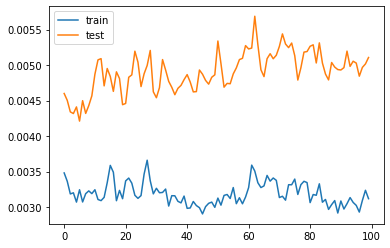

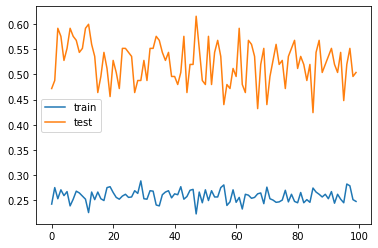

Test loss:0.14%
Test score:39.20%
Train on 1125 samples, validate on 125 samples
Epoch 1/100
1125/1125 - 0s - loss: 0.0032 - accuracy: 0.2773 - val_loss: 0.0013 - val_accuracy: 0.3920
Epoch 2/100
1125/1125 - 0s - loss: 0.0032 - accuracy: 0.2507 - val_loss: 0.0015 - val_accuracy: 0.4080
Epoch 3/100
1125/1125 - 0s - loss: 0.0033 - accuracy: 0.2747 - val_loss: 0.0014 - val_accuracy: 0.4000
Epoch 4/100
1125/1125 - 0s - loss: 0.0034 - accuracy: 0.2800 - val_loss: 0.0018 - val_accuracy: 0.4240
Epoch 5/100
1125/1125 - 0s - loss: 0.0032 - accuracy: 0.2649 - val_loss: 0.0012 - val_accuracy: 0.4240
Epoch 6/100
1125/1125 - 0s - loss: 0.0031 - accuracy: 0.2436 - val_loss: 0.0015 - val_accuracy: 0.4400
Epoch 7/100
1125/1125 - 0s - loss: 0.0033 - accuracy: 0.2693 - val_loss: 0.0012 - val_accuracy: 0.4240
Epoch 8/100
1125/1125 - 0s - loss: 0.0032 - accuracy: 0.2631 - val_loss: 0.0012 - val_accuracy: 0.3600
Epoch 9/100
1125/1125 - 0s - loss: 0.0033 - accuracy: 0.2773 - val_loss: 0.0013 - val_accuracy:

Epoch 80/100
1125/1125 - 0s - loss: 0.0030 - accuracy: 0.2649 - val_loss: 0.0015 - val_accuracy: 0.3360
Epoch 81/100
1125/1125 - 0s - loss: 0.0031 - accuracy: 0.2702 - val_loss: 0.0021 - val_accuracy: 0.3840
Epoch 82/100
1125/1125 - 0s - loss: 0.0032 - accuracy: 0.2471 - val_loss: 0.0018 - val_accuracy: 0.4160
Epoch 83/100
1125/1125 - 0s - loss: 0.0030 - accuracy: 0.2791 - val_loss: 0.0020 - val_accuracy: 0.3360
Epoch 84/100
1125/1125 - 0s - loss: 0.0032 - accuracy: 0.2507 - val_loss: 0.0018 - val_accuracy: 0.4400
Epoch 85/100
1125/1125 - 0s - loss: 0.0031 - accuracy: 0.2702 - val_loss: 0.0016 - val_accuracy: 0.3520
Epoch 86/100
1125/1125 - 0s - loss: 0.0031 - accuracy: 0.2631 - val_loss: 0.0017 - val_accuracy: 0.3520
Epoch 87/100
1125/1125 - 0s - loss: 0.0031 - accuracy: 0.2382 - val_loss: 0.0012 - val_accuracy: 0.4000
Epoch 88/100
1125/1125 - 0s - loss: 0.0032 - accuracy: 0.2569 - val_loss: 0.0013 - val_accuracy: 0.4320
Epoch 89/100
1125/1125 - 0s - loss: 0.0031 - accuracy: 0.2800 - 

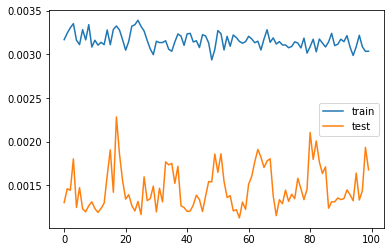

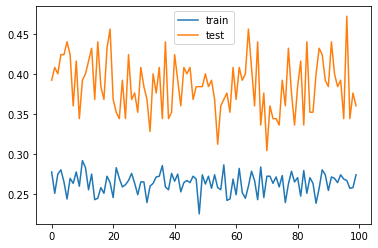

Test loss:0.14%
Test score:34.80%
Train on 1125 samples, validate on 125 samples
Epoch 1/100
1125/1125 - 0s - loss: 0.0034 - accuracy: 0.2524 - val_loss: 0.0015 - val_accuracy: 0.3440
Epoch 2/100
1125/1125 - 0s - loss: 0.0031 - accuracy: 0.2596 - val_loss: 0.0017 - val_accuracy: 0.3520
Epoch 3/100
1125/1125 - 0s - loss: 0.0035 - accuracy: 0.2516 - val_loss: 0.0016 - val_accuracy: 0.3440
Epoch 4/100
1125/1125 - 0s - loss: 0.0035 - accuracy: 0.2818 - val_loss: 0.0013 - val_accuracy: 0.3120
Epoch 5/100
1125/1125 - 0s - loss: 0.0033 - accuracy: 0.2596 - val_loss: 0.0015 - val_accuracy: 0.3280
Epoch 6/100
1125/1125 - 0s - loss: 0.0031 - accuracy: 0.2613 - val_loss: 0.0016 - val_accuracy: 0.3040
Epoch 7/100
1125/1125 - 0s - loss: 0.0030 - accuracy: 0.2373 - val_loss: 0.0016 - val_accuracy: 0.3200
Epoch 8/100
1125/1125 - 0s - loss: 0.0030 - accuracy: 0.2756 - val_loss: 0.0016 - val_accuracy: 0.3520
Epoch 9/100
1125/1125 - 0s - loss: 0.0031 - accuracy: 0.2676 - val_loss: 0.0018 - val_accuracy:

1125/1125 - 0s - loss: 0.0030 - accuracy: 0.2853 - val_loss: 0.0023 - val_accuracy: 0.3040
Epoch 80/100
1125/1125 - 0s - loss: 0.0032 - accuracy: 0.2329 - val_loss: 0.0026 - val_accuracy: 0.2960
Epoch 81/100
1125/1125 - 0s - loss: 0.0033 - accuracy: 0.2498 - val_loss: 0.0028 - val_accuracy: 0.3120
Epoch 82/100
1125/1125 - 0s - loss: 0.0031 - accuracy: 0.2453 - val_loss: 0.0029 - val_accuracy: 0.2960
Epoch 83/100
1125/1125 - 0s - loss: 0.0031 - accuracy: 0.2542 - val_loss: 0.0024 - val_accuracy: 0.2880
Epoch 84/100
1125/1125 - 0s - loss: 0.0030 - accuracy: 0.2391 - val_loss: 0.0021 - val_accuracy: 0.3200
Epoch 85/100
1125/1125 - 0s - loss: 0.0031 - accuracy: 0.2587 - val_loss: 0.0024 - val_accuracy: 0.3040
Epoch 86/100
1125/1125 - 0s - loss: 0.0030 - accuracy: 0.2516 - val_loss: 0.0021 - val_accuracy: 0.2960
Epoch 87/100
1125/1125 - 0s - loss: 0.0031 - accuracy: 0.2578 - val_loss: 0.0019 - val_accuracy: 0.3040
Epoch 88/100
1125/1125 - 0s - loss: 0.0031 - accuracy: 0.2551 - val_loss: 0.0

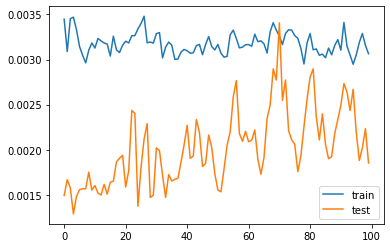

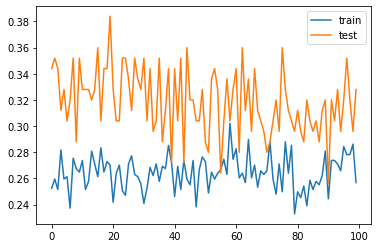

Test loss:0.16%
Test score:38.00%
Train on 1125 samples, validate on 125 samples
Epoch 1/100
1125/1125 - 0s - loss: 0.0033 - accuracy: 0.2898 - val_loss: 0.0013 - val_accuracy: 0.4160
Epoch 2/100
1125/1125 - 0s - loss: 0.0032 - accuracy: 0.2667 - val_loss: 0.0016 - val_accuracy: 0.4000
Epoch 3/100
1125/1125 - 0s - loss: 0.0035 - accuracy: 0.2436 - val_loss: 0.0021 - val_accuracy: 0.4160
Epoch 4/100
1125/1125 - 0s - loss: 0.0043 - accuracy: 0.2569 - val_loss: 0.0026 - val_accuracy: 0.4320
Epoch 5/100
1125/1125 - 0s - loss: 0.0047 - accuracy: 0.2444 - val_loss: 0.0020 - val_accuracy: 0.3760
Epoch 6/100
1125/1125 - 0s - loss: 0.0041 - accuracy: 0.2560 - val_loss: 0.0016 - val_accuracy: 0.3120
Epoch 7/100
1125/1125 - 0s - loss: 0.0034 - accuracy: 0.2702 - val_loss: 0.0020 - val_accuracy: 0.3680
Epoch 8/100
1125/1125 - 0s - loss: 0.0036 - accuracy: 0.2747 - val_loss: 0.0023 - val_accuracy: 0.3200
Epoch 9/100
1125/1125 - 0s - loss: 0.0039 - accuracy: 0.2569 - val_loss: 0.0018 - val_accuracy:

1125/1125 - 0s - loss: 0.0031 - accuracy: 0.2693 - val_loss: 0.0021 - val_accuracy: 0.3920
Epoch 80/100
1125/1125 - 0s - loss: 0.0032 - accuracy: 0.2649 - val_loss: 0.0021 - val_accuracy: 0.3360
Epoch 81/100
1125/1125 - 0s - loss: 0.0034 - accuracy: 0.2631 - val_loss: 0.0019 - val_accuracy: 0.3680
Epoch 82/100
1125/1125 - 0s - loss: 0.0033 - accuracy: 0.2596 - val_loss: 0.0017 - val_accuracy: 0.3840
Epoch 83/100
1125/1125 - 0s - loss: 0.0034 - accuracy: 0.2578 - val_loss: 0.0017 - val_accuracy: 0.4080
Epoch 84/100
1125/1125 - 0s - loss: 0.0033 - accuracy: 0.2631 - val_loss: 0.0018 - val_accuracy: 0.3520
Epoch 85/100
1125/1125 - 0s - loss: 0.0030 - accuracy: 0.2427 - val_loss: 0.0018 - val_accuracy: 0.4160
Epoch 86/100
1125/1125 - 0s - loss: 0.0032 - accuracy: 0.2551 - val_loss: 0.0019 - val_accuracy: 0.4160
Epoch 87/100
1125/1125 - 0s - loss: 0.0036 - accuracy: 0.2462 - val_loss: 0.0021 - val_accuracy: 0.4320
Epoch 88/100
1125/1125 - 0s - loss: 0.0036 - accuracy: 0.2649 - val_loss: 0.0

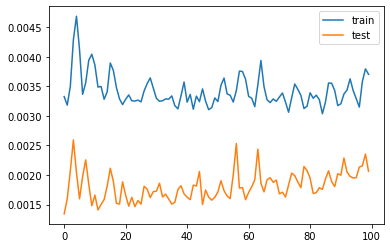

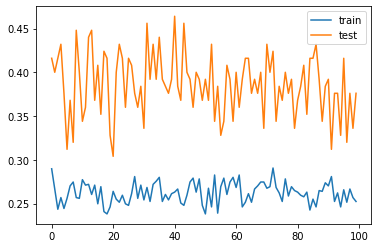

Test loss:0.18%
Test score:37.60%


In [6]:
# design LSTM Model
model = Sequential()
model.add(LSTM(32, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(n_predict, kernel_initializer='lecun_uniform', activation='relu'))
optimizer = Adam(lr=0.001, decay=1e-6)
model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

# store score & loss for each fold
score_arr = []
loss_arr = []

# num split for cross-validation
num_splits = 10

# k-fold cross validation
kf = KFold(n_splits=num_splits)
kf.get_n_splits(X)
KFold(n_splits=num_splits, random_state=None, shuffle=False)

# begin cross-validation procedure
for train_index, test_index in kf.split(X):
    
    # split x and y into train and test
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # fit Model
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=2, shuffle=False)
    
    # plot loss history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()

    # plot loss history
    pyplot.plot(history.history['accuracy'], label='train')
    pyplot.plot(history.history['val_accuracy'], label='test')
    pyplot.legend()
    pyplot.show()
        
    # Score model
    test_X = test_X.reshape((test_X.shape[0], n_input, n_features))
    loss, score = model.evaluate(test_X, test_y, verbose=0)
    print('Test loss:%.2f%%' % (loss * 100))
    print('Test score:%.2f%%' % (score * 100))
    
    loss_arr.append(loss)
    score_arr.append(score)

In [7]:
# summarize k-fold results
for i in range(len(score_arr)):
    print('K-Fold {}: Loss:{:.4f}, Score:{:.3f}'.format(i+1, loss_arr[i], score_arr[i] * 100))

K-Fold 1: Loss:0.0028, Score:39.600
K-Fold 2: Loss:0.0021, Score:36.400
K-Fold 3: Loss:0.0022, Score:32.800
K-Fold 4: Loss:0.0023, Score:39.600
K-Fold 5: Loss:0.0018, Score:39.600
K-Fold 6: Loss:0.0019, Score:35.600
K-Fold 7: Loss:0.0014, Score:39.200
K-Fold 8: Loss:0.0014, Score:34.800
K-Fold 9: Loss:0.0016, Score:38.000
K-Fold 10: Loss:0.0018, Score:37.600


In [8]:
#test_X = test_X.reshape((test_X.shape[0], n_input, n_features))

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_input*n_features))

print(yhat.shape)
print(test_X[:, -(n_features-1):].shape)

# initialize empty pred_arr and actual_arr
pred_arr = np.empty((test_X.shape[0], 1))
actual_arr = np.empty((test_X.shape[0], 1))

# invert scaling for forecast
for i in range(0, yhat.shape[1]):
    yhat_col = yhat[:, i].reshape(len(yhat[:, i]), 1)    
    inv_yhat = concatenate((yhat_col, test_X[:, -(n_features-1):]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    inv_yhat = inv_yhat.reshape(len(inv_yhat), 1)
    pred_arr = np.append(pred_arr, inv_yhat, axis=1)    
pred_arr = pred_arr[:,1:]

# invert scaling for actual
for i in range(0, test_y.shape[1]):
    test_y_col = test_y[:, i].reshape(len(test_y[:, i]), 1)
    inv_y = concatenate((test_y_col, test_X[:, -(n_features-1):]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    inv_y = inv_y.reshape(len(inv_y), 1)
    actual_arr = np.append(actual_arr, inv_y, axis=1)
actual_arr = actual_arr[:,1:]      

(250, 7)
(250, 10)


In [9]:
print("\n######  RMSE #######\n")

rmse_arr = []
# calculate RMSE
for i in range(0, actual_arr.shape[1]):
    rmse = sqrt(mean_squared_error(actual_arr[:, i], pred_arr[:, i]))
    rmse_arr.append(rmse)
    print('t+{} RMSE: {:.3f}'.format(i+1, rmse))
print('Avg. RMSE: {:.3f}'.format(np.mean(rmse_arr)))
    
print("\n######  MAE  #######\n")
    
mae_arr = []
# calculate MAE
for i in range(0, actual_arr.shape[1]):
    mae = mean_absolute_error(actual_arr[:, i], pred_arr[:, i])
    mae_arr.append(mae)
    print('t+{} MAE: {:.3f}'.format(i+1, mae))
print('Avg. MAE: {:.3f}'.format(np.mean(mae_arr)))


######  RMSE #######

t+1 RMSE: 1514.326
t+2 RMSE: 1668.329
t+3 RMSE: 1908.768
t+4 RMSE: 2080.710
t+5 RMSE: 2284.920
t+6 RMSE: 2478.887
t+7 RMSE: 2553.466
Avg. RMSE: 2069.915

######  MAE  #######

t+1 MAE: 1101.568
t+2 MAE: 1221.007
t+3 MAE: 1440.656
t+4 MAE: 1620.305
t+5 MAE: 1696.849
t+6 MAE: 1852.442
t+7 MAE: 1771.944
Avg. MAE: 1529.253


In [10]:
test_X = test_X.reshape((test_X.shape[0], n_input, n_features))

inv_yhat = pred_arr[:, 0].reshape(len(pred_arr), 1)
inv_y = actual_arr[:, 0].reshape(len(actual_arr), 1)

print(inv_yhat.shape)
print(inv_y.shape)

# print predicted vs expected
num_days = test_y.shape[0]
accuracy_scores = []
for i in range(len(inv_y[:num_days])):
    if inv_y[i] > inv_yhat[i]:
        score = inv_yhat[i] / inv_y[i] * 100
        if score > 0:
            accuracy_scores.append(score)
    else:
        score = inv_y[i] / inv_yhat[i] * 100
        if score > 0:
            accuracy_scores.append(score)
    print('Day=%d, Expected=%.2f, Predicted=%.2f, Accuracy=%.2f%%' % (i+1, inv_y[i], inv_yhat[i], score ))
print("Avg. Accuracy %.2f%% (+/- %.2f%%)" % (np.mean(accuracy_scores), np.std(accuracy_scores)))

(250, 1)
(250, 1)
Day=1, Expected=53804.00, Predicted=50360.57, Accuracy=93.60%
Day=2, Expected=53537.00, Predicted=53831.27, Accuracy=99.45%
Day=3, Expected=53562.00, Predicted=53263.86, Accuracy=99.44%
Day=4, Expected=53535.00, Predicted=53054.48, Accuracy=99.10%
Day=5, Expected=51744.00, Predicted=49419.57, Accuracy=95.51%
Day=6, Expected=25672.00, Predicted=27369.48, Accuracy=93.80%
Day=7, Expected=27036.00, Predicted=27997.13, Accuracy=96.57%
Day=8, Expected=52946.00, Predicted=50946.99, Accuracy=96.22%
Day=9, Expected=53826.00, Predicted=53397.90, Accuracy=99.20%
Day=10, Expected=53721.00, Predicted=53359.74, Accuracy=99.33%
Day=11, Expected=53621.00, Predicted=52716.07, Accuracy=98.31%
Day=12, Expected=51267.00, Predicted=49510.26, Accuracy=96.57%
Day=13, Expected=25792.00, Predicted=27362.12, Accuracy=94.26%
Day=14, Expected=26995.00, Predicted=27851.50, Accuracy=96.92%
Day=15, Expected=52005.00, Predicted=50669.95, Accuracy=97.43%
Day=16, Expected=51546.00, Predicted=52984.23,

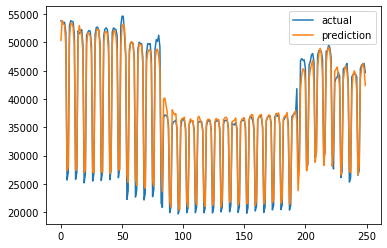

In [11]:
# plot actual vs prediction (All Test Data)
num_days = test_y.shape[0]
pyplot.plot(list(inv_y[:num_days]), label='actual')
pyplot.plot(inv_yhat[:num_days], label='prediction')
pyplot.legend()
pyplot.show()

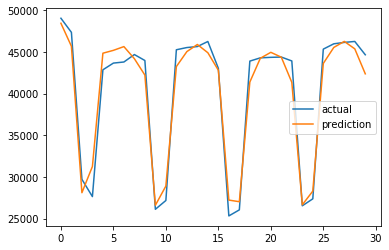

In [12]:
# plot actual vs prediction (Last 30 days)
num_days = 30
pyplot.plot(list(inv_y[-num_days:]), label='actual')
pyplot.plot(inv_yhat[-num_days:], label='prediction')
pyplot.legend()
pyplot.show()

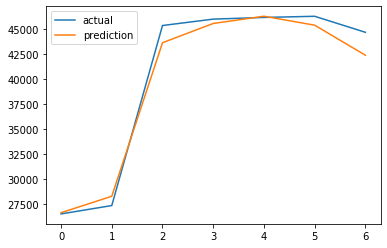

In [13]:
# plot actual vs prediction (Last 7 days)
num_days = 7
pyplot.plot(list(inv_y[-num_days:]), label='actual')
pyplot.plot(inv_yhat[-num_days:], label='prediction')
pyplot.legend()
pyplot.show()

In [14]:
# Predictions Numeric
test_X = test_X.reshape((test_X.shape[0], n_input, n_features))
prediction = model.predict(test_X[-1:])
print(prediction.shape)

new_pred_arr = []
for i in range(0, prediction.shape[1]):
    test_X = test_X.reshape((test_X.shape[0], n_input*n_features))
    inv_pred = concatenate(([[prediction[0][i]]], test_X[:prediction.shape[0], -(n_features-1):]), axis=1)
    inv_pred = inv_pred.reshape(1, inv_pred.shape[1])
    inv_pred = scaler.inverse_transform(inv_pred)
    inv_pred = inv_pred[:,0]
    new_pred_arr.append(inv_pred[0])
print(new_pred_arr)

(1, 7)
[42385.89, 26168.707, 27071.977, 42849.836, 41242.43, 40579.457, 41826.016]


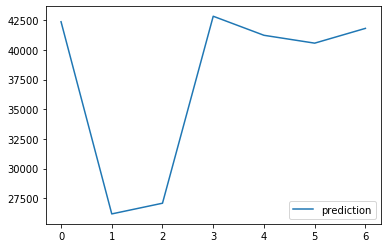

In [15]:
# plot prediction
pyplot.plot(new_pred_arr, label='prediction')
pyplot.legend()
pyplot.show()